## Feature engineering

In this notebook, we carry out the initial cleaning of the data. 

Overall, due to the relatively small number of samples in the training dataset, we aim to reduce the dimensionality of the data by:
1. Eliminating features with too many **missing values**
2. **Grouping** categorical variables that have a low count
3. Eliminating features with **little information**, such as those that are mostly constant

We also prepare the text data by vectorizing it.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
def read_data(filename, data_dir='data'):
    df = pd.read_csv(os.path.join(data_dir, filename), index_col=0)
    df.fillna('?', inplace=True)
    return df

df_train = read_data('diab_train.csv')
df_val = read_data('diab_validation.csv')
df_test = read_data('diab_test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 9011 to 1625
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      6000 non-null   object
 1   gender                    6000 non-null   object
 2   age                       6000 non-null   object
 3   weight                    6000 non-null   object
 4   admission_type_id         6000 non-null   object
 5   discharge_disposition_id  6000 non-null   object
 6   admission_source_id       6000 non-null   object
 7   time_in_hospital          6000 non-null   int64 
 8   payer_code                6000 non-null   object
 9   medical_specialty         6000 non-null   object
 10  num_lab_procedures        6000 non-null   int64 
 11  num_procedures            6000 non-null   int64 
 12  num_medications           6000 non-null   int64 
 13  number_outpatient         6000 non-null   int64 
 14  number_emergency     

In [3]:
df_train.head(10)

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
9011,AfricanAmerican,Male,[60-70),?,Emergency,Discharged to home,Emergency Room,4,MC,?,...,No,No,No,No,No,No,0,Acute pericarditis in diseases classified else...,Secondary malignant neoplasm of kidney,"Congestive heart failure, unspecified"
9569,Caucasian,Female,[70-80),?,Elective,?,Physician Referral,1,?,Family/GeneralPractice,...,No,No,No,No,Ch,Yes,1,Malignant essential hypertension,"Spinal stenosis, unspecified region",Diabetes mellitus without mention of complicat...
6090,Caucasian,Female,[80-90),?,Urgent,Discharged/transferred to SNF,Emergency Room,2,MC,Emergency/Trauma,...,No,No,No,No,Ch,Yes,0,"Urinary tract infection, site not specified",Streptococcus infection in conditions classifi...,"Congestive heart failure, unspecified"
4282,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,4,DM,?,...,No,No,No,No,Ch,Yes,1,"Respiratory abnormality, unspecified","Hypertensive chronic kidney disease, malignant...",Diabetes mellitus without mention of complicat...
9084,Caucasian,Male,[80-90),?,Elective,?,Physician Referral,13,?,?,...,No,No,No,No,Ch,Yes,1,Coronary atherosclerosis of unspecified type o...,"Chronic airway obstruction, not elsewhere clas...",Malignant essential hypertension
1776,Caucasian,Female,[70-80),?,Emergency,Discharged/transferred to SNF,Emergency Room,3,?,InternalMedicine,...,No,No,No,No,No,Yes,0,Cerebral thrombosis without mention of cerebra...,"Urinary tract infection, site not specified",Diabetes mellitus without mention of complicat...
797,Caucasian,Male,[60-70),[75-100),Elective,Discharged/transferred to ICF,Transfer from another health care facility,5,MC,InternalMedicine,...,No,No,No,No,No,No,0,Acquired hypertrophic pyloric stenosis,"Congestive heart failure, unspecified",Paroxysmal supraventricular tachycardia
413,Caucasian,Female,[60-70),?,Emergency,Discharged to home,Transfer from a hospital,3,MC,InternalMedicine,...,No,No,No,No,No,Yes,0,Basilar artery syndrome,Malignant hypertensive heart disease without h...,"Congestive heart failure, unspecified"
8150,Caucasian,Male,[20-30),?,Emergency,Discharged to home,Emergency Room,2,?,?,...,No,No,No,No,No,No,0,Hyperosmolality and/or hypernatremia,Adenovirus infection in conditions classified ...,"Personal history of allergy, other than to med..."
5317,Asian,Male,[80-90),?,Urgent,Discharged/transferred to another short term h...,Emergency Room,1,SP,Family/GeneralPractice,...,No,No,No,No,Ch,Yes,1,Closed fracture of acetabulum,Emphysematous bleb,Closed fracture of unspecified part of upper e...


###  Dealing with missing values
The columns: **'weight'**, **'payer_code'** and **'medical_specialty'** have too many missing values to provide meaningful information to the machine learning algorithm, so we just remove them.

For the other columns with a smaller number of missing values, we just leave the missing value as a '?'. In the categorical features, this would correspond to a new 'unknown' category. 

In [4]:
print("Missing values per column")
for column in df_train.columns:
    num_missing_values = (df_train[column] == '?').sum()
    if num_missing_values > 0:
        print(column, num_missing_values)

Missing values per column
race 124
weight 5757
admission_type_id 416
discharge_disposition_id 283
admission_source_id 551
payer_code 3211
medical_specialty 2440
diag_1 1
diag_2 34
diag_3 122
diag_1_desc 1
diag_2_desc 34
diag_3_desc 122


/home/carlos/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [5]:
columns_to_remove = ['weight', 'payer_code', 'medical_specialty']
df_train.drop(columns_to_remove, axis='columns', inplace=True)
df_val.drop(columns_to_remove, axis='columns', inplace=True)
df_test.drop(columns_to_remove, axis='columns', inplace=True)

assert(not df_train.isna().values.any())

### Feature engineering: age
The younger age groups have too few data points, so we group them into one new age group to normalize the data.

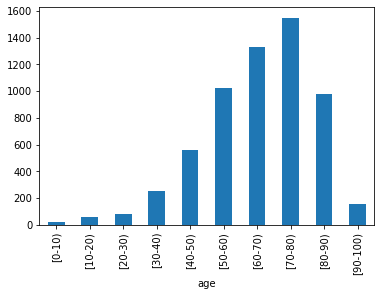

In [6]:
df_train.groupby('age').size().plot(kind='bar')
plt.show()

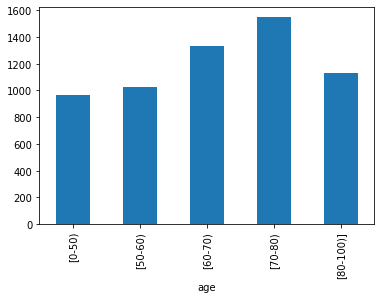

In [7]:
def normalize_age(df):    
    df['age'] = df['age']. \
                      map(lambda x: '[0-50)' if x in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else x). \
                      map(lambda x: '[80-100)]' if x in ['[80-90)', '[90-100)'] else x)
    return df

df_train = normalize_age(df_train)
df_test = normalize_age(df_test)
df_val = normalize_age(df_val)
df_train.groupby('age').size().plot(kind='bar')
plt.show()

### Feature engineering: Medicine columns
By looking at the statistics we can see that most of these columns are almost constant, so we decided to remove them.

The only relevant column is 'insulin'

In [8]:
total = df_train.shape[0]
medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
                      'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
                      'citoglipton', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 
                      'metformin.rosiglitazone', 'metformin.pioglitazone']

print('Column   # dominant entry   % dominant entry  total entries')
for column in medication_columns:
    dominant_cnt = df_train[column].value_counts()[0]
    percentage_dominant_cnt = int(dominant_cnt / total * 100)
    print("{}  {}  {}%  {}".format(column, dominant_cnt, str(percentage_dominant_cnt), str(total)))

Column   # dominant entry   % dominant entry  total entries
metformin  4793  79%  6000
repaglinide  5923  98%  6000
nateglinide  5964  99%  6000
chlorpropamide  5992  99%  6000
glimepiride  5710  95%  6000
acetohexamide  6000  100%  6000
glipizide  5221  87%  6000
glyburide  5297  88%  6000
tolbutamide  5999  99%  6000
pioglitazone  5605  93%  6000
rosiglitazone  5545  92%  6000
acarbose  5985  99%  6000
miglitol  5996  99%  6000
troglitazone  6000  100%  6000
tolazamide  5998  99%  6000
examide  6000  100%  6000
citoglipton  6000  100%  6000
insulin  3116  51%  6000
glyburide.metformin  5968  99%  6000
glipizide.metformin  6000  100%  6000
glimepiride.pioglitazone  6000  100%  6000
metformin.rosiglitazone  6000  100%  6000
metformin.pioglitazone  6000  100%  6000


In [9]:
df_train['insulin'].value_counts()

No        3116
Steady    1794
Down       590
Up         500
Name: insulin, dtype: int64

In [10]:
#medication_columns.remove('insulin')

df_train.drop(medication_columns, axis='columns', inplace=True)
df_val.drop(medication_columns, axis='columns', inplace=True)
df_test.drop(medication_columns, axis='columns', inplace=True)

In [11]:
df_train.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'change', 'diabetesMed', 'readmitted', 'diag_1_desc', 'diag_2_desc',
       'diag_3_desc'],
      dtype='object')

### Feature engineering: discharge, admission type and admission source
We reduce the dimensionality by grouping disposition and admission into fewer categories.

Discharge disposition split into those sent home or not.

Admission source split into Emergency room, Physician Referral and Other.

Admission type split into Emergency and Other.

In [12]:
for dataset in [df_train, df_val, df_test]:
    dataset['discharge_disposition_id'].replace('Not Mapped', '?', inplace=True)
    dataset['admission_source_id'].replace(['Not Available', 'Not Mapped'], ['?', '?'], inplace=True)
    dataset['admission_type_id'].replace(['Not Available', 'Not Mapped'], ['?', '?'], inplace=True)
    
    home_vals = ['Discharged to home', \
                    'Discharged/transferred to home with home health service', \
                    'Discharged/transferred to home under care of Home IV provider']
    safe_vals = ['Emergency Room', 'Physician Referral']
    dataset['discharge_disposition_id'] = pd.Series(['Home' if val in home_vals else 'Not Home' for val in dataset['discharge_disposition_id']], index=dataset.index)
    dataset['admission_source_id'] = pd.Series([val if val in safe_vals else 'Other' for val in dataset['admission_source_id']], index=dataset.index)
    dataset['admission_type_id'] = pd.Series([val if val == 'Emergency' else 'Other' for val in dataset['admission_type_id']], index=dataset.index)

### Feature engineering: diag

For the diagnosis text, there is a one to one mapping between diagnostic codes and descriptions. Thus, we do not attempt to learn word embeddings in order to find some vector representation for each diagnosis text.

However, similar text in the diagnosis description of two diagnoses may indicate some similarity between them. To encode this, e take vectors of frequency counts of words that appear with a frequency of at least 5% the size of the corpus, ignoring stopwords, as a representation of that text. We choose to avoid TF-idf due to the repetition of the same diagnosis texts.

For the diagnostic codes, we take two different approaches:

- For the first one, we attempt to drastically reduce the dimensionality of the data by keeping only the primary diagnosis and splitting these into those with a diabetes diagnosis (Codes 250) and those without. 

- For the second approach, we combine all diagnosis codes and represent a patient diagnosis as a vector whose length is the number of different diagnosis codes. In order to prevent a huge blow up in dimensions, we take only the top 200 most frequent diagnoses, and group all others under 'uncommon'. There is a 1 for each of the diagnoses for that patient and a 0 everywhere else. 

We treat the diagnosis text the same way in both.

Despite the one-to-one mapping between diagnosis text and codes, we find that incorporating the text results in a slight improvement over not having it. We speculate that the text therefore encodes some meaningful information regarding the similarity of diagnoses.

In [13]:
df_train_alt = df_train.copy()
df_test_alt = df_test.copy()
df_val_alt = df_val.copy()

In [14]:
[(df_train['diag_' + str(i)].value_counts().values == df_train['diag_' + str(i) + '_desc'].value_counts().values).all() for i in [1, 2, 3]]

[True, True, True]

In [15]:
for dataset in [df_train, df_val, df_test]:
    dataset['diag_1'] = pd.Series(["yes" if val[0:4] == '250' else "no" for val in dataset['diag_1']], index=dataset.index)
    dataset['diag_desc'] = dataset[['diag_1_desc', 'diag_2_desc', 'diag_3_desc']].agg(' '.join, axis=1)
    dataset.drop(columns=['diag_2', 'diag_3', 'diag_2_desc', 'diag_3_desc'], inplace=True)
    
vectorizer = CountVectorizer(min_df=0.05, stop_words='english')
vectorizer.fit(df_train.diag_desc.append([df_val.diag_desc, df_test.diag_desc]))
vocab = list(vectorizer.vocabulary_.keys())

for dataset in [df_train, df_val, df_test]:
    dataset[vocab] = pd.DataFrame(vectorizer.transform(dataset.diag_desc).todense(), index=dataset.index)
    dataset.drop(columns=['diag_desc'], inplace=True)

In [16]:
df_train.to_csv(os.path.join('data', 'diab_train_filtered.csv'))
df_test.to_csv(os.path.join('data', 'diab_test_filtered.csv'))
df_val.to_csv(os.path.join('data', 'diab_validation_filtered.csv'))

#### Alternatively, we keep all the diagnosis information and create one-hot encodings for each patient
We combine diag_1, 2 and 3 into a one hot encoding for each patient combining the 3.

Take only the 200 most frequent diagnoses, grouping the rest into a new one called 'uncommon'.

In [17]:
from collections import Counter
l = df_train_alt[['diag_1', 'diag_2', 'diag_3']].values.tolist()
l = [list(set(li)) for li in l]
l = [el for li in l for el in li]
uncommon = [el[0] for el in Counter(l).most_common()[201:]]

In [18]:
for dataset in [df_train_alt, df_val_alt, df_test_alt]:
    dataset['diag_1'].replace(uncommon, 'uncommon', inplace=True)
    dataset['diag_2'].replace(uncommon, 'uncommon', inplace=True)
    dataset['diag_3'].replace(uncommon, 'uncommon', inplace=True)
    dataset['diag_desc'] = dataset[['diag_1_desc', 'diag_2_desc', 'diag_3_desc']].agg(' '.join, axis=1)
    dataset.drop(columns=['diag_2_desc', 'diag_3_desc'], inplace=True)
    dataset['diag_full'] = dataset[['diag_1', 'diag_2', 'diag_3']].values.tolist()

mlb = MultiLabelBinarizer()
# avoid oob error, capture all possible diagnosis codes
mlb.fit(df_train_alt.diag_full.append([df_val_alt.diag_full, df_test_alt.diag_full]))
for dataset in [df_train_alt, df_val_alt, df_test_alt]:
    dataset[mlb.classes_] = pd.DataFrame(mlb.transform(dataset.diag_full), index=dataset.index)
    dataset.drop(columns=['diag_1', 'diag_2', 'diag_3', 'diag_full'], inplace=True)

vectorizer = CountVectorizer(min_df=0.05, stop_words='english')
vectorizer.fit(df_train_alt.diag_desc.append([df_val_alt.diag_desc, df_test_alt.diag_desc]))
vocab = list(vectorizer.vocabulary_.keys())

for dataset in [df_train_alt, df_val_alt, df_test_alt]:
    dataset[vocab] = pd.DataFrame(vectorizer.transform(dataset.diag_desc).todense(), index=dataset.index)
    dataset.drop(columns=['diag_desc'], inplace=True)

In [19]:
df_train_alt.to_csv(os.path.join('data', 'diab_train_alt.csv'))
df_test_alt.to_csv(os.path.join('data', 'diab_test_alt.csv'))
df_val_alt.to_csv(os.path.join('data', 'diab_validation_alt.csv'))